In [1]:
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from parflow import Run, read_pfb, write_pfb, ParflowBinaryReader,read_pfb_sequence

In [3]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/"

Change some input files:

In [4]:
with ParflowBinaryReader(root_dir+'perm1.pfb') as pfb:
    data = pfb.read_all_subgrids()
    hdr = pfb.read_header()

In [5]:
data[:,-1,0]

array([0.252, 0.252, 0.252, 0.252, 0.252, 0.252, 0.252, 0.252, 0.252,
       0.252, 0.252, 0.252, 0.252, 0.18 , 0.18 , 0.18 , 0.18 , 0.18 ,
       0.18 , 0.252, 0.252, 0.252, 0.252, 0.252, 0.252, 0.002, 0.002,
       0.002, 0.002, 0.002])

conversion m/h -> m/s

In [6]:
data = data/3600

In [73]:
# tests:::
# all with 
#SA_mil_1.Geom.H2.RelPerm.Alpha = 1.5
#SA_mil_1.Geom.H2.RelPerm.N = 1.7
#and
#SA_mil_1.Geom.H3.RelPerm.Alpha = 1.84
#SA_mil_1.Geom.H3.RelPerm.N = 2.35

#data = data*0.0 + 5.55*10**-7
# testé: 12% de Ke !
# data = data[::-1,:,:]
# testé, ne change rien, Ke = 12%
#data[-8:-5,:,:] = data[-1,0,0]
# testé, Ke=12%
#data[-6:-5,:,:] = data[-1,0,0]
# testé, Ke = 10.5%
# data[-11:-5,:,:] = 0.01/3600
# test, ne change rien (Ke = 0)

# le dernier test: Kr=18% avec
#SA_mil_1.Geom.H2.RelPerm.Alpha =5
#SA_mil_1.Geom.H2.RelPerm.N = 3
#et
#SA_mil_1.Geom.H3.RelPerm.Alpha =5
#SA_mil_1.Geom.H3.RelPerm.N = 3

# et en changeant seulement N et Alpha de H2 et H3, pas le Ks de H2: Ke = 8%

In [74]:
hdr

{'x': 0.0,
 'y': 0.0,
 'z': 0.0,
 'nx': 1,
 'ny': 32,
 'nz': 30,
 'dx': 100.0,
 'dy': 25.0,
 'dz': 1.0,
 'n_subgrids': 1}

In [75]:
write_pfb(root_dir+'perm1s.pfb',data,**hdr)


Verification

In [76]:
with ParflowBinaryReader(root_dir+'perm1s.pfb') as pfb:
    data2 = pfb.read_all_subgrids()
    hdr2 = pfb.read_header()

In [77]:
data2.shape

(30, 32, 1)

In [78]:
data2[:,0,0]

array([7.00000000e-05, 7.00000000e-05, 7.00000000e-05, 7.00000000e-05,
       7.00000000e-05, 7.00000000e-05, 7.00000000e-05, 7.00000000e-05,
       7.00000000e-05, 7.00000000e-05, 7.00000000e-05, 7.00000000e-05,
       7.00000000e-05, 5.00000000e-05, 5.00000000e-05, 5.00000000e-05,
       5.00000000e-05, 5.00000000e-05, 5.00000000e-05, 2.77777778e-06,
       2.77777778e-06, 2.77777778e-06, 2.77777778e-06, 2.77777778e-06,
       2.77777778e-06, 5.55555556e-07, 5.55555556e-07, 5.55555556e-07,
       5.55555556e-07, 5.55555556e-07])

In [79]:
hdr2

{'x': 0.0,
 'y': 0.0,
 'z': 0.0,
 'nx': 1,
 'ny': 32,
 'nz': 30,
 'dx': 100.0,
 'dy': 25.0,
 'dz': 1.0,
 'n_subgrids': 1}

In [80]:
with ParflowBinaryReader('/home/hectorb/PARFLOW/PROJECTS/Ara/resolution2020/inputs/ara250/ara250_/ara250.out.perm_x.pfb') as pfb:
    datatmp = pfb.read_all_subgrids()
    hdrtmp = pfb.read_header()

In [81]:
datatmp.shape

(15, 20, 20)

In [82]:
datatmp[:,10,10]

array([1.5e-02, 1.5e-02, 1.5e-02, 1.5e-02, 1.5e-02, 1.5e-02, 1.5e-02,
       3.6e-04, 3.6e-04, 3.6e-04, 3.6e-04, 3.6e-04, 4.0e-01, 4.0e-01,
       4.0e-01])

### Extract rainfall events

Read forcings

In [83]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(os.sep.join([root_dir,'forc_bani_5min_2006_2009.txt']),header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2006 00:00:00', periods=len(forc), freq='5min')
P=forc['P']*5*60
forc

SWin      LWin    P         T   WindX  WindY    Press  \
2006-01-01 00:00:00  3.7305  316.1700  0.0  291.1000  0.9565    0.0  98450.0   
2006-01-01 00:05:00  3.7260  316.3100  0.0  291.0508  0.9113    0.0  98450.0   
2006-01-01 00:10:00  3.7215  316.4500  0.0  291.0017  0.8660    0.0  98450.0   
2006-01-01 00:15:00  3.7170  316.5900  0.0  290.9525  0.8208    0.0  98450.0   
2006-01-01 00:20:00  3.7125  316.7300  0.0  290.9033  0.7755    0.0  98450.0   
...                     ...       ...  ...       ...     ...    ...      ...   
2009-12-31 23:10:00 -0.2190  318.3567  0.0  292.3033  0.2318    0.0  98750.0   
2009-12-31 23:15:00 -0.2070  318.2350  0.0  292.1475  0.1910    0.0  98750.0   
2009-12-31 23:20:00 -0.1950  318.1133  0.0  291.9917  0.1502    0.0  98750.0   
2009-12-31 23:25:00 -0.1830  317.9917  0.0  291.8358  0.1093    0.0  98750.0   
2009-12-31 23:30:00 -0.1710  317.8700  0.0  291.6800  0.0685    0.0  98750.0   

                         Hs  
2006-01-01 00:00:00  0.0026  
2006-01-01 00:05:00  0.0026  
2006-01-01 00:10:00  0.0026  
2006-01-01 00:15:00  0.0026  
2006-01-01 00:20:00  0.0026  
...                     ...  
2009-12-31 23:10:00  0.0022  
2009-12-31 23:15:00  0.0022  
2009-12-31 23:20:00  0.0022  
2009-12-31 23:25:00  0.0022  
2009-12-31 23:30:00  0.0022  

[420763 rows x 8 columns]

In [84]:
data_ag_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/Pluie-Le_après-Aménagement.csv"
data_ag = pd.read_csv(data_ag_file)

<AxesSubplot:xlabel='Pluie (mm)', ylabel='LR_avant'>

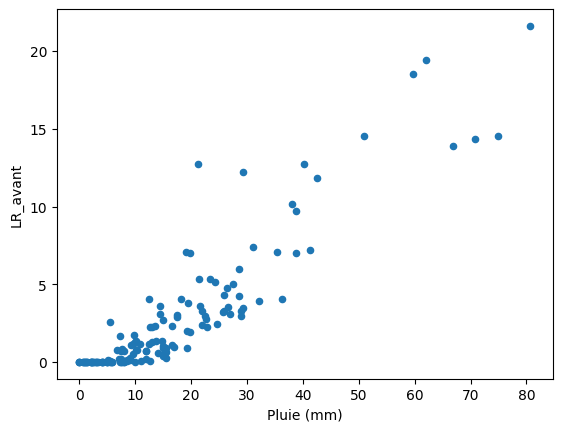

In [85]:
data_ag.plot.scatter(x='Pluie (mm)',y = 'LR_avant')

date des évènements issus des simus 30mn forçage bani

In [86]:
data_evts_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/evts_banizoumbou_6h_90_21.txt"
data_evts = pd.read_csv(data_evts_file,sep='\t')

<AxesSubplot:xlabel='Duration', ylabel='Volume'>

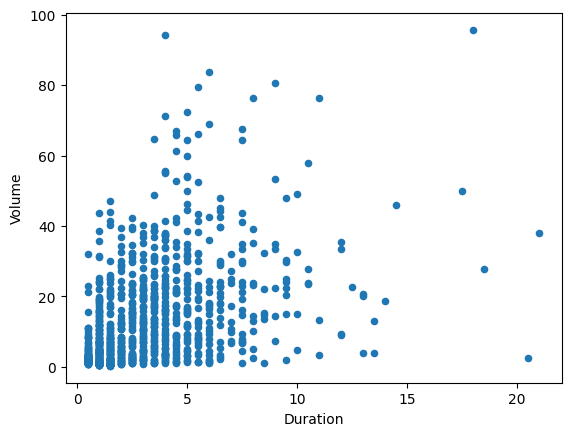

In [87]:
data_evts.plot.scatter(x='Duration',y = 'Volume')

In [88]:
data_evts.describe()

Duration       Volume    Intensity
count  1266.000000  1266.000000  1266.000000
mean      2.899684    11.294336     4.448623
std       2.537507    14.037115     5.659564
min       0.500000     0.240000     0.114118
25%       1.500000     1.052500     0.599455
50%       2.000000     5.520000     2.756667
75%       4.000000    17.125000     5.960000
max      21.000000    95.670000    63.780000

In [89]:
data_evts.Starting = data_evts.Starting.apply(lambda x: pd.to_datetime(x))
data_evts.End = data_evts.End.apply(lambda x: pd.to_datetime(x))

In [90]:
data_evts.Starting.dt.year

0       1990
1       1990
2       1990
3       1990
4       1990
        ... 
1261    2021
1262    2021
1263    2021
1264    2021
1265    2021
Name: Starting, Length: 1266, dtype: int64

In [91]:
subset = data_evts.loc[(data_evts.Volume>15) & (data_evts.Volume<20) & \
              (data_evts.Starting.dt.year>2006) & (data_evts.Starting.dt.year<2009) &\
              (data_evts.Duration>2.5) & (data_evts.Duration<4.5),:]
subset

Starting                 End  Duration  Volume  Intensity
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500

Plot chosen events

In [92]:
subset.End.iloc[0]

Timestamp('2007-07-23 14:00:00')

In [93]:
subset.End.iloc[0]+pd.Timedelta(minutes=30)

Timestamp('2007-07-23 14:30:00')

In [94]:
pevent = P.loc[(P.index>= subset.Starting.iloc[0]+pd.Timedelta(minutes=10)) & \
      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]
pevent

2007-07-23 11:40:00    0.00
2007-07-23 11:45:00    2.28
2007-07-23 11:50:00    6.06
2007-07-23 11:55:00    4.08
2007-07-23 12:00:00    0.66
2007-07-23 12:05:00    0.75
2007-07-23 12:10:00    0.87
2007-07-23 12:15:00    0.42
2007-07-23 12:20:00    0.27
2007-07-23 12:25:00    0.24
2007-07-23 12:30:00    0.18
2007-07-23 12:35:00    0.18
2007-07-23 12:40:00    0.18
2007-07-23 12:45:00    0.18
2007-07-23 12:50:00    0.18
2007-07-23 12:55:00    0.21
2007-07-23 13:00:00    0.21
2007-07-23 13:05:00    0.24
2007-07-23 13:10:00    0.24
2007-07-23 13:15:00    0.18
2007-07-23 13:20:00    0.15
2007-07-23 13:25:00    0.15
2007-07-23 13:30:00    0.12
2007-07-23 13:35:00    0.12
2007-07-23 13:40:00    0.12
2007-07-23 13:45:00    0.12
2007-07-23 13:50:00    0.12
2007-07-23 13:55:00    0.15
2007-07-23 14:00:00    0.15
2007-07-23 14:05:00    0.15
2007-07-23 14:10:00    0.15
2007-07-23 14:15:00    0.15
2007-07-23 14:20:00    0.15
2007-07-23 14:25:00    0.00
Freq: 5T, Name: P, dtype: float64

In [95]:
vol = pevent.sum()
print(vol)

19.409999999999997


<AxesSubplot:>

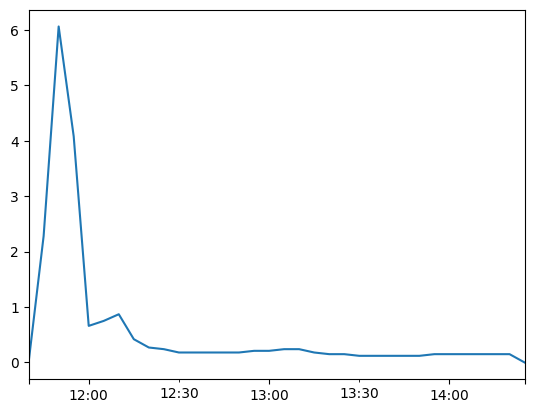

In [30]:
pevent.plot()

Interpolate at 1s

switch from mm/5mn to mm/s

In [114]:
peventrs = pevent.resample('1s').interpolate('linear')/(60*5)

<AxesSubplot:>

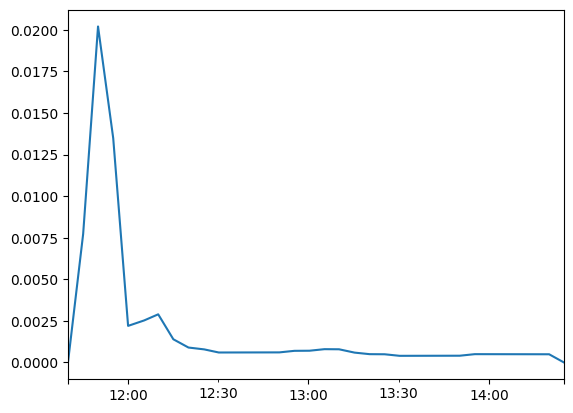

In [115]:
peventrs.plot()

Load the simulation

In [116]:
hill = Run.from_definition(root_dir+'SA_mil_1.pfidb')

Change simulation stoptime accordingly:

In [117]:
peventrs.size

9901

In [101]:
hill.TimingInfo.StopTime = peventrs.size

replace the cycle names and bc values: (recall to recompile parflow changing input_database.h)

In [102]:
hill.Cycle.rain.Names = ' '.join('_%d'%i for i in range(peventrs.size))

In [103]:
for i in range(peventrs.size):
    hill.Cycle.rain['_%d'%i].Length = 1

hill.Cycle.rain._0.Length

5

In [104]:
hill.Patch.z_upper.BCPressure.Cycle = 'rain'

In [105]:
for i in range(peventrs.size):
    #mm/10s -> m / s ?
    hill.Patch.z_upper.BCPressure['_%d'%i].Value = -peventrs.iloc[i]/1000
hill.Patch.z_upper.BCPressure._0.Value 

-0.0

In [106]:
hill.Patch.z_upper.BCPressure._1.Value 

-1.2666666666666666e-07

In [107]:
hill.Patch.z_upper.BCPressure._1000.Value 

-7.666666666666666e-07

Tests:

In [108]:
0.031*6

0.186

In [109]:
#hill.Cell._19.dzScale.Value = 0.093
#hill.Cell._20.dzScale.Value = 0.048
#hill.Cell._21.dzScale.Value = 0.024
#hill.Cell._22.dzScale.Value = 0.012
#hill.Cell._23.dzScale.Value = 0.006
#hill.Cell._24.dzScale.Value = 0.003

In [110]:
wdir = root_dir+'results/'
if os.path.exists(wdir):
    shutil.rmtree(wdir)
os.mkdir(wdir)

In [111]:
shutil.copy(root_dir+'slopey.pfb',wdir+'slopey.pfb')
shutil.copy(root_dir+'perm1s.pfb',wdir+'perm1s.pfb')

'/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results/perm1s.pfb'

In [112]:
#hill.ComputationalGrid.NZ = 1
hill.dist(wdir+'slopey.pfb')
#hill.ComputationalGrid.NZ = 30
hill.dist(wdir+'perm1s.pfb')

In [113]:
hill.run(working_directory=wdir,skip_validation=False)


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec noticed that process rank 0 with PID 0 on node ige-mcpn-19 exited on signal 15 (Terminated).
--------------------------------------------------------------------------
# =========================================================================

SystemExit: 1

/home/hectorb/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [48]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01",freq='h'):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq=freq),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [49]:
peventrs.index[0]

Timestamp('2007-07-23 11:40:00', freq='S')

In [50]:
ds1 = read_and_process_pf_outputs(wdir,date_start=peventrs.index[0],freq='s')
with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
h['dx']

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


100.0

In [51]:
ds1 = ds1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

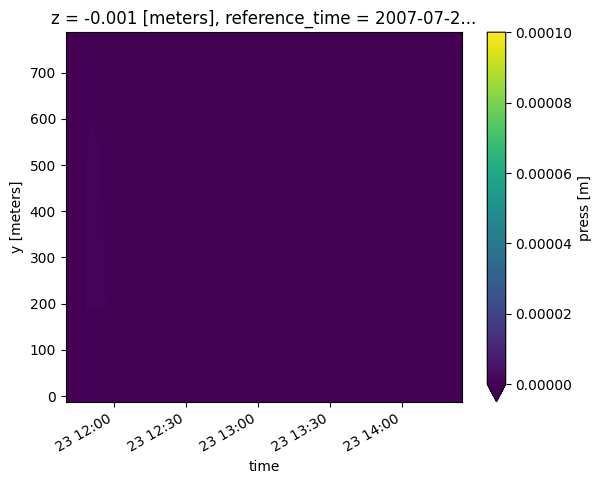

In [52]:
ds1.press.isel(z=0).plot(x='time',vmax=0.0001,vmin =0)

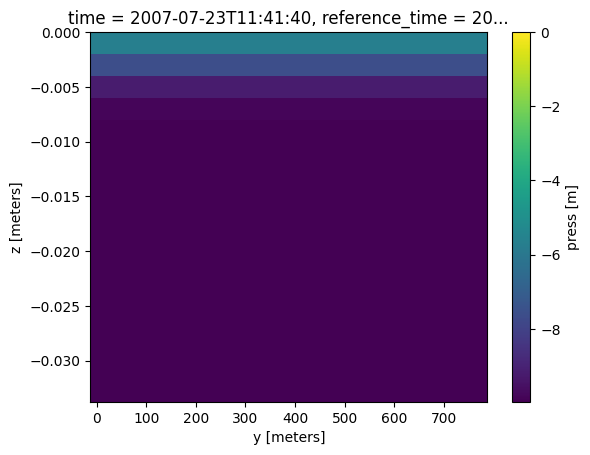

In [53]:
(ds1.press.isel(time=100)).isel(z=[i for i in range(6)]).plot(x='y',vmax=0)

In [54]:
Dds1 = ds1.press.differentiate(coord="z")

In [72]:
(ds1.press.isel(y=8)).isel(z=[i for i in range(6)]).isel(time=100)

<xarray.DataArray 'press' (z: 6)>
array([-5.71073365, -7.59262989, -9.20870098, -9.8413865 , -9.966369  ,
       -9.96486069])
Coordinates:
    y               float64 200.0
  * z               (z) float64 -0.001 -0.003 -0.005 -0.007 -0.009 -0.0255
    time            datetime64[ns] 2007-07-23T11:41:40
    reference_time  datetime64[ns] 2007-07-23T11:40:00
Attributes:
    units:    m

In [70]:
(Dds1.isel(y=8)).isel(z=[i for i in range(6)]).isel(time=100)

<xarray.DataArray 'press' (z: 6)>
array([ 9.40948118e+02,  8.74491831e+02,  5.62189152e+02,  1.89417007e+02,
        5.57255597e+01, -2.99014884e-01])
Coordinates:
    y               float64 200.0
  * z               (z) float64 -0.001 -0.003 -0.005 -0.007 -0.009 -0.0255
    time            datetime64[ns] 2007-07-23T11:41:40
    reference_time  datetime64[ns] 2007-07-23T11:40:00

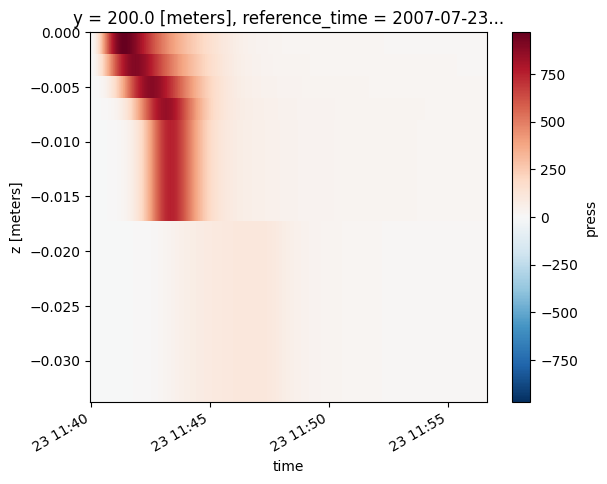

In [55]:
(Dds1.isel(y=8)).isel(z=[i for i in range(6)]).isel(time=[i for i in range(1000)]).plot(x='time')

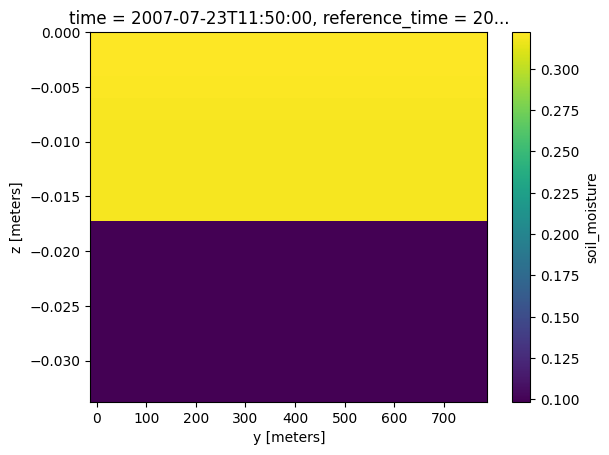

In [56]:
(ds1.soil_moisture.isel(time=600)).isel(z=[i for i in range(6)]).plot(x='y')

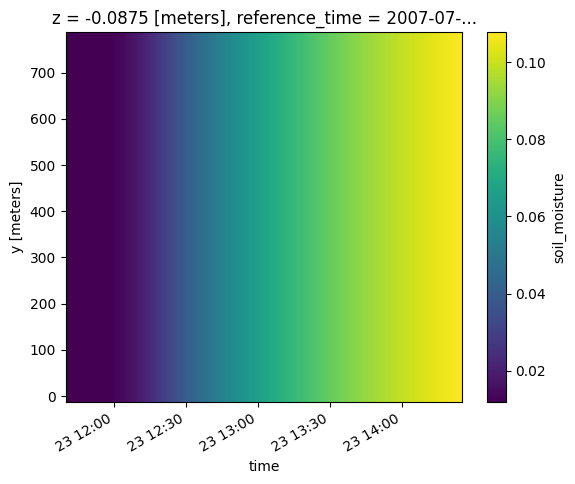

In [57]:
ds1.soil_moisture.isel(z=7).plot(x='time')

In [58]:
SM_uphill = ds1.soil_moisture.isel(y=-1).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)
SM_downhill = ds1.soil_moisture.isel(y=3).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)

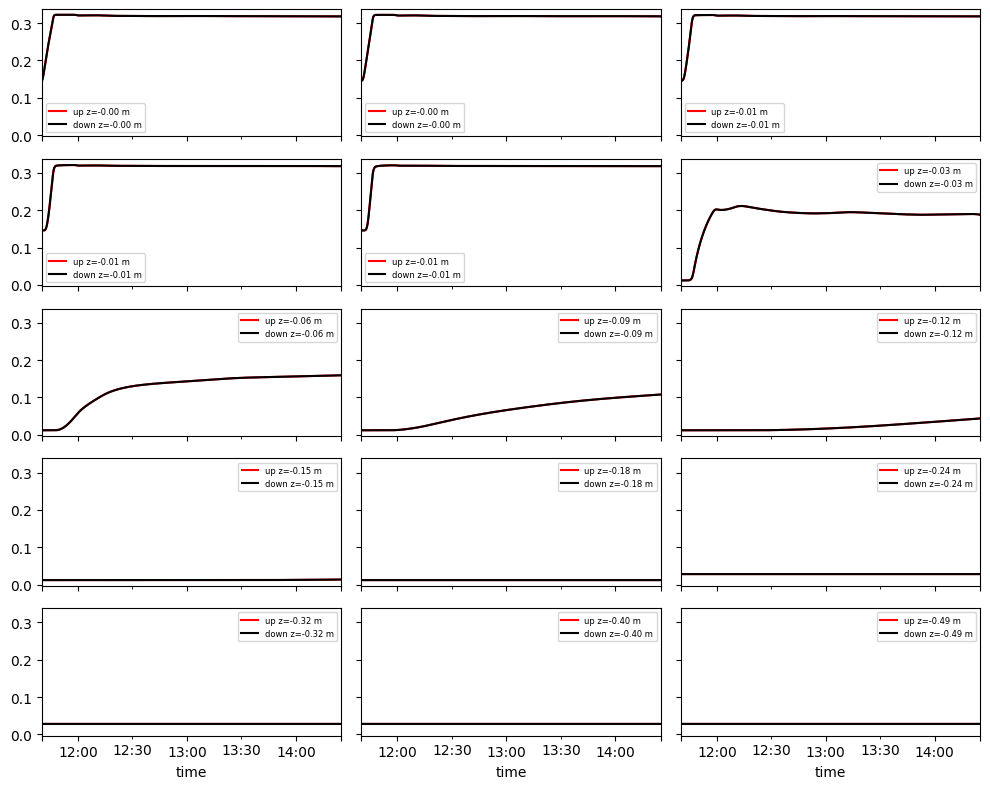

In [59]:
import calendar
fig, axes = plt.subplots(5,3,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    SM_uphill.iloc[:,i].plot(ax=ax,color='r',label = 'up z=%2.2f m'%float(SM_uphill.columns[i]))
    SM_downhill.iloc[:,i].plot(ax=ax,color='k',label = 'down z=%2.2f m'%float(SM_downhill.columns[i]))
    ax.legend(fontsize=6)
plt.tight_layout()

In [60]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [61]:
manning = hill.Mannings.Geom.domain.Value
ds1 = ds1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.press.data[:,0,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         h['dx'],h['dy'],manning)))
ds1.Q.attrs['units']='m3/timestep'
ds1 = ds1.assign(Qmm = lambda x: x.Q/h['dx']/h['nx']/h['dy']/h['ny']*1000)

/tmp/ipykernel_374086/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


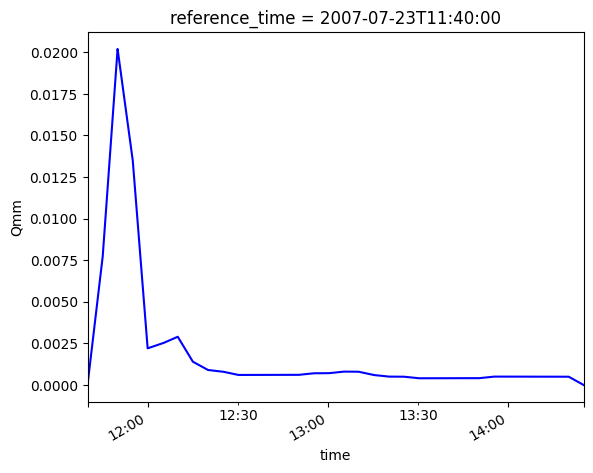

In [62]:
fig, ax = plt.subplots(1,1)
peventrs.plot(ax=ax,color='b')
ds1.Qmm.plot(ax=ax,color = 'k')


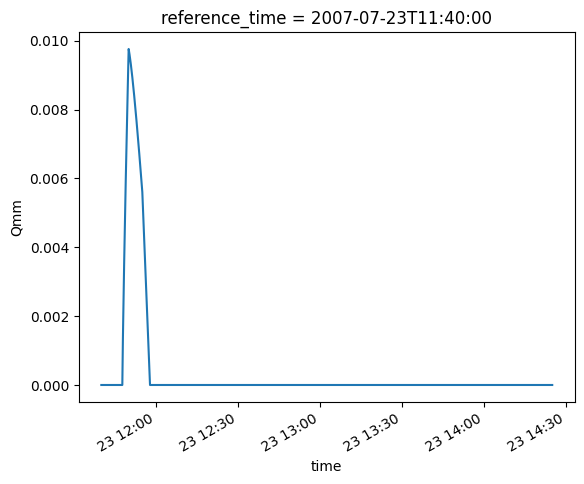

In [63]:
ds1.Qmm.plot()

In [64]:
Ke = 100*ds1.Qmm.sum()/vol
print("Ke = %2.2f %%"%Ke)

Ke = 18.47 %


In [68]:
#lame d'eau
ds1.Qmm.sum()

<xarray.DataArray 'Qmm' ()>
array(3.58420418)
Coordinates:
    reference_time  datetime64[ns] 2007-07-23T11:40:00

In [65]:
storage = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage = storage - storage[0]

In [66]:
storage

time
2007-07-23 11:40:00     0.000000
2007-07-23 11:40:01     0.000025
2007-07-23 11:40:02     0.000076
2007-07-23 11:40:03     0.000152
2007-07-23 11:40:04     0.000253
                         ...    
2007-07-23 14:24:56    15.825786
2007-07-23 14:24:57    15.825791
2007-07-23 14:24:58    15.825794
2007-07-23 14:24:59    15.825796
2007-07-23 14:25:00    15.825796
Freq: S, Name: storage, Length: 9901, dtype: float64